In [ ]:
try:
    import implicit
    import lightfm
except ImportError:
    !pip install -qU implicit
    !pip install lightfm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, ndcg_score, accuracy_score
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.neighbors import NearestNeighbors
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import csr_matrix, coo_matrix
from implicit.als import AlternatingLeastSquares
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ============================ Загрузка и подготовка данных ============================
df = pd.read_csv("calls.csv", sep=";")
df = df[~df['owner'].str.contains('cookies', na=False)]
df = df.sort_values('start_time')

owners = df['owner'].unique()
mids = df['mid'].unique()

train_size = int(len(df) * 0.7)
df_train = df[:train_size]
df_test = df[train_size:]

def build_matrix(df, owners, mids, normalize=False):
    pivot = df.pivot_table(index='owner', columns='mid', values='id', aggfunc='count').fillna(0)
    pivot = pivot.reindex(index=owners, columns=mids, fill_value=0)

    mat = pivot.values

    if normalize:
        row_sums = mat.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        mat = mat / row_sums
    return mat

X_train = build_matrix(df_train, owners, mids, normalize=True)
X_test = build_matrix(df_test, owners, mids, normalize=True)

# ============================ Популярность ============================
def get_popular_services(df, mids):
    counts = df['mid'].value_counts().reindex(mids, fill_value=0)
    counts_max = np.max(counts.values)
    return np.argsort(counts.values/counts_max)[::-1]

popular_services = get_popular_services(df_train, mids)

# ============================ Методы ============================
class KNNRecommender:
    def __init__(self, n_neighbors=3):
        self.model = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')

    def fit(self, X):
        self.X = X
        self.model.fit(X)
        self.indices = self.model.kneighbors(X, return_distance=False)

    def predict(self):
        preds = np.zeros_like(self.X)
        for i, neighbors in enumerate(self.indices):
            neighbors = neighbors[1:]
            preds[i] = self.X[neighbors].mean(axis=0)
        return preds

class SVDRecommender:
    def __init__(self, model):
        self.model = model

    def fit(self, X):
        self.X = X
        self.embeddings = self.model.fit_transform(X)

    def predict(self):
        return self.model.inverse_transform(self.embeddings)

# ============================ LightFMTuner ============================
class LightFMTuner:
    def __init__(self, param_grid):
        self.param_grid = param_grid

    def tune(self, df_train, owners, mids, X_train, used_train, actual_test, mids_list, popular_services, k):
        results = []
        for loss in self.param_grid['loss']:
            for epochs in self.param_grid['epochs']:
                for no_components in self.param_grid['no_components']:
                    dataset = Dataset()
                    dataset.fit(owners, mids)
                    interactions, _ = dataset.build_interactions([(row['owner'], row['mid']) for _, row in df_train.iterrows()])
                    model = LightFM(loss=loss, no_components=no_components)
                    model.fit(interactions, epochs=epochs, num_threads=4)

                    uid_map = dataset.mapping()[0]
                    iid_map = dataset.mapping()[2]
                    num_items = len(iid_map)
                    preds = []
                    for user in owners:
                        uid = uid_map[user]
                        scores = model.predict(uid, np.arange(num_items))
                        preds.append(scores)
                    preds = np.array(preds)
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids_list, preds, k)
                    results.append({
                        'loss': loss,
                        'epochs': epochs,
                        'no_components': no_components,
                        **metrics
                    })
                    print(f"loss={loss}, epochs={epochs}, no_components={no_components} -> {metrics}")
        return pd.DataFrame(results)

class KNNLightFMTuner:
    def __init__(self, param_grid):
        self.param_grid = param_grid

    def tune(self, df_train, owners, mids, X_train, used_train, actual_test, mids_list, popular_services, k):
        results = []
        knn_model = KNNRecommender(n_neighbors=4)
        knn_model.fit(X_train)
        knn_preds = knn_model.predict()

        hybrid_matrix = X_train + 1 * knn_preds

        for loss in self.param_grid['loss']:
            for epochs in self.param_grid['epochs']:
                for no_components in self.param_grid['no_components']:
                    dataset = Dataset()
                    dataset.fit(owners, mids)
                    interactions, _ = dataset.build_interactions([(owners[i], mids[j]) for i, j in zip(*hybrid_matrix.nonzero())])

                    model = LightFM(loss=loss, no_components=no_components)
                    model.fit(interactions, epochs=epochs, num_threads=4)

                    uid_map = dataset.mapping()[0]
                    iid_map = dataset.mapping()[2]
                    num_items = len(iid_map)
                    preds = []
                    for user in owners:
                        uid = uid_map[user]
                        scores = model.predict(uid, np.arange(num_items))
                        preds.append(scores)
                    preds = np.array(preds)
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids_list, preds, k)
                    results.append({
                        'loss': loss,
                        'epochs': epochs,
                        'no_components': no_components,
                        **metrics
                    })
                    print(f"loss={loss}, epochs={epochs}, no_components={no_components} -> {metrics}")
        return pd.DataFrame(results)

class LightFMRecommender:
    def __init__(self, loss, no_components, epochs):
        self.loss = loss
        self.no_components = no_components
        self.epochs = epochs

    def fit(self, df, owners, mids):
        dataset = Dataset()
        dataset.fit(owners, mids)
        interactions, _ = dataset.build_interactions([(row['owner'], row['mid']) for _, row in df.iterrows()])
        self.model = LightFM(loss=self.loss, no_components=self.no_components)
        self.model.fit(interactions, epochs=self.epochs, num_threads=4)
        self.dataset = dataset
        self.owners = owners
        self.mids = mids
        self.interactions = interactions

    def predict(self):
        uid_map = self.dataset.mapping()[0]
        iid_map = self.dataset.mapping()[2]
        inv_iid_map = {v: k for k, v in iid_map.items()}
        num_items = len(iid_map)
        preds = []
        for user in self.owners:
            uid = uid_map[user]
            scores = self.model.predict(uid, np.arange(num_items))
            preds.append(scores)
        return np.array(preds)

class HybridKNNLightFMRecommender:
    def __init__(self, loss='warp', no_components=20, epochs=20, knn_neighbors=4, alpha=1):
        self.loss = loss
        self.no_components = no_components
        self.epochs = epochs
        self.knn_neighbors = knn_neighbors
        self.alpha = alpha

    def fit(self, df_train, owners, mids, X_train):
        knn_model = KNNRecommender(n_neighbors=self.knn_neighbors)
        knn_model.fit(X_train)
        knn_preds = knn_model.predict()

        hybrid_matrix = X_train + self.alpha * knn_preds

        dataset = Dataset()
        dataset.fit(owners, mids)
        interactions, _ = dataset.build_interactions([(owners[i], mids[j]) for i, j in zip(*hybrid_matrix.nonzero())])

        self.model = LightFM(loss=self.loss, no_components=self.no_components)
        self.model.fit(interactions, epochs=self.epochs, num_threads=4)

        self.dataset = dataset
        self.owners = owners
        self.mids = mids

    def predict(self):
        uid_map = self.dataset.mapping()[0]
        iid_map = self.dataset.mapping()[2]
        num_items = len(iid_map)
        preds = []
        for user in self.owners:
            uid = uid_map[user]
            scores = self.model.predict(uid, np.arange(num_items))
            preds.append(scores)
        return np.array(preds)

def best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k, loss):
    # Тюнинг LightFM
    lf_param_grid = {
        'loss': [loss],
        'epochs': [10, 20],
        'no_components': [10, 20, 40]
    }

    lf_tuner = LightFMTuner(param_grid=lf_param_grid)
    lf_results = lf_tuner.tune(df_train, owners, mids, X_train, used_train, actual_test, mids, popular_services, k)

    best_lf_row = lf_results.sort_values(by='precision', ascending=False).iloc[0]
    return LightFMRecommender(
        loss=best_lf_row['loss'],
        no_components=int(best_lf_row['no_components']),
        epochs=int(best_lf_row['epochs'])
    )

def best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k, loss):
    # Тюнинг LightFM
    lf_param_grid = {
        'loss': [loss],
        'epochs': [10, 20],
        'no_components': [10, 20, 40]
    }

    lf_tuner = KNNLightFMTuner(param_grid=lf_param_grid)
    lf_results = lf_tuner.tune(df_train, owners, mids, X_train, used_train, actual_test, mids, popular_services, k)

    best_lf_row = lf_results.sort_values(by='precision', ascending=False).iloc[0]
    return HybridKNNLightFMRecommender(
        loss=best_lf_row['loss'],
        no_components=int(best_lf_row['no_components']),
        epochs=int(best_lf_row['epochs']),
        alpha=1.0
    )
# ============================ ALS с тюннингом ============================
class ALSRecommender:
    def __init__(self, factors=20, regularization=0.1, iterations=10):
        self.factors = factors
        self.regularization = regularization
        self.iterations = iterations

    def fit(self, X):
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.regularization,
            iterations=self.iterations
        )
        self.X = csr_matrix(X * 20)
        self.model.fit(self.X)

    def predict(self):
        return self.model.user_factors @ self.model.item_factors.T
def best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k):
    def tune_als(X_train, X_test, used_train, actual_test, mids, popular_services, k, param_grid):
        results = []
        for factors in param_grid['factors']:
            for reg in param_grid['regularization']:
                for iters in param_grid['iterations']:
                    model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iters)
                    X = csr_matrix(X_train * 20)
                    model.fit(X)
                    preds = model.user_factors @ model.item_factors.T
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids, preds, k)
                    results.append({
                        'factors': factors,
                        'regularization': reg,
                        'iterations': iters,
                        **metrics
                    })
                    print(f"factors={factors}, reg={reg}, iters={iters} -> {metrics}")
        return pd.DataFrame(results)

    # Пример запуска тюнинга ALS
    param_grid = {
        'factors': [10, 20, 40],
        'regularization': [0.01, 0.1, 1],
        'iterations': [10, 20]
    }

    als_tuning_results = tune_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15, param_grid=param_grid)

    # Добавим лучшую ALS-модель в сравнение (по precision, например)
    best_row = als_tuning_results.sort_values(by='precision', ascending=False).iloc[0]
    print("\nBest ALS params:", best_row[['factors', 'regularization', 'iterations']].to_dict())

    best_als = ALSRecommender(
        factors=int(best_row['factors']),
        regularization=float(best_row['regularization']),
        iterations=int(best_row['iterations'])
    )
    return best_als

# ========================================================

class WRMFRecommender:
    def fit(self, X):
        self.model = AlternatingLeastSquares(factors=20, iterations=10)
        self.X = csr_matrix(X * 20)
        self.model.fit(self.X)

    def predict(self):
        return self.model.user_factors @ self.model.item_factors.T

class PopularRecommender:
    def __init__(self, popular_items):
        self.popular_items = popular_items

    def fit(self, X):
        self.X = X
        pass  # No fitting required

    def predict(self):
        return np.tile(self.popular_items, (self.X.shape[0], 1))

class RandomRecommender:
    def fit(self, X):
        self.X = X
        self.num_items = X.shape[1]

    def predict(self):
        return np.random.rand(self.X.shape[0], self.num_items)

# ============================ Оценка ============================
def get_used_services(X):
    return [set(np.where(row > 0)[0]) for row in X]

def get_recommendations(scores, used, popular, k):
    recs = []
    for i, user_scores in enumerate(scores):
        sorted_items = np.argsort(user_scores)[::-1]
        filtered = [item for item in sorted_items if item not in used[i]]
        if len(filtered) < k:
            extra = [item for item in popular if item not in used[i] and item not in filtered]
            filtered += extra
        recs.append(filtered[:k])
    return recs

def evaluate(recs, actual, all_items, scores, k):
    results = {'accuracy': [], 'precision': [], 'recall': [], 'ndcg': []}
    for i in range(len(recs)):
        y_true = [1 if j in actual[i] else 0 for j in range(len(all_items))]
        y_pred = [1 if j in recs[i] else 0 for j in range(len(all_items))]

        rel_true = [1 if j in actual[i] else 0 for j in recs[i]]
        rel_score = [scores[i][j] if j in recs[i] else 0 for j in recs[i]]

        results['accuracy'].append(accuracy_score(y_true, y_pred))
        results['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        results['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        results['ndcg'].append(ndcg_score([rel_true], [rel_score]) if sum(rel_true) > 0 else 0)

    return {m: np.mean(vals) for m, vals in results.items()}

# ============================ Запуск моделей ============================


used_train = get_used_services(X_train)
actual_test = get_used_services(X_test)
k = 10

models = {
    'KNN': KNNRecommender(),
    'PCA': SVDRecommender(PCA(n_components=5)),
    'NMF': SVDRecommender(NMF(n_components=5, init='random', random_state=0)),
    'SVD': SVDRecommender(TruncatedSVD(n_components=5)),'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'LightFM-WARP': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'PHCF-BPR': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'KNN+LightFM-WARP': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'KNN+PHCF-BPR': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'WRMF': WRMFRecommender(),
    'Popular': PopularRecommender(popular_services),
    'Random': RandomRecommender()
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name == 'LightFM-WARP' or name == 'PHCF-BPR':
        model.fit(df_train, owners, mids)
        preds = model.predict()
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
        preds = model.predict()
    else:
        model.fit(X_train)
        preds = model.predict()

    recs = get_recommendations(preds, used_train, popular_services, k)
    metrics = evaluate(recs, actual_test, mids, preds, k)
    for m, v in metrics.items():
        print(f"{m.capitalize()}: {v:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.03039358302516197), 'ndcg': np.float64(0.0850420421790078)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04305051673472726), 'ndcg': np.float64(0.11188537901009232)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.026058736585052377), 'ndcg': np.float64(0.062198854583592825)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.03157894736842106), 'recall': np.float64(0.06069661332819227), 'ndcg': np.float64(0.08437292064256285)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.13651713338041388)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.1364103410306361)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.032637683953473426), 'ndcg': np.float64(0.08257711987037185)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04793744267428478), 'ndcg': np.float64(0.08585684228423662)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.02560889402994666), 'ndcg': np.float64(0.06212358157843251)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.1404863787715008)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.03438082385450806), 'ndcg': np.float64(0.07214612409543807)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04793744267428478), 'ndcg': np.float64(0.10475409404399053)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8823062681830204), 'precision': np.float64(0.021052631578947368), 'recall': np.float64(0.016836964205385257), 'ndcg': np.float64(0.056590764177568614)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.1474375164976248)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1335639343026486)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}

Best ALS params: {'factors': 10.0, 'regularization': 0.1, 'iterations': 20.0}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824561), 'recall': np.float64(0.0312932681353734), 'ndcg': np.float64(0.11388522611074739)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.03438082385450806), 'ndcg': np.float64(0.07215085711941023)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824562), 'recall': np.float64(0.06114645588329798), 'ndcg': np.float64(0.0826764475890326)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.03393098129940235), 'ndcg': np.float64(0.06722211479607869)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.13655630227230123)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.1366239257301916)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824561), 'recall': np.float64(0.03528050896471949), 'ndcg': np.float64(0.07371734310648485)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.022071495755706282), 'ndcg': np.float64(0.06370359014939679)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04315275367906947), 'ndcg': np.float64(0.06578588877100676)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.13464956888077687)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1528080031081144)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8823062681830204), 'precision': np.float64(0.021052631578947368), 'recall': np.float64(0.030747030747030744), 'ndcg': np.float64(0.09297677035702283)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04928185849238481), 'ndcg': np.float64(0.10270606832215949)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04315275367906947), 'ndcg': np.float64(0.08662899308343495)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.11806414518646652)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}

Best ALS params: {'factors': 10.0, 'regularization': 0.1, 'iterations': 10.0}
loss=warp, epochs=10, no_components=10 -> {'accuracy': np.float64(0.8849510711451997), 'precision': np.float64(0.03859649122807017), 'recall': np.float64(0.09786324786324785), 'ndcg': np.float64(0.20229819370354435)}
loss=warp, epochs=10, no_components=20 -> {'accuracy': np.float64(0.8881248346998148), 'precision': np.float64(0.05964912280701754), 'recall': np.float64(0.12082931688194848), 'ndcg': np.float64(0.2244598507015015)}
loss=warp, epochs=10, no_components=40 -> {'accuracy': np.float64(0.8860089923300714), 'precision': np.float64(0.045614035087719294), 'recall': np.float64(0.08210751237067027), 'ndcg': np.float64(0.2070912856342165)}
loss=warp, epochs=20, no_components=10 -> {'accuracy': np.float6

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.9080
Precision: 0.0368
Recall: 0.0373
Ndcg: 0.0645

=== LightFM-WARP ===
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.0971
Ndcg: 0.2082

=== PHCF-BPR ===
Accuracy: 0.9117
Precision: 0.0737
Recall: 0.0822
Ndcg: 0.1982

=== KNN+LightFM-WARP ===
Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0615
Ndcg: 0.1187

=== KNN+PHCF-BPR ===
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.0571
Ndcg: 0.1011

=== WRMF ===


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.9069
Precision: 0.0263
Recall: 0.0290
Ndcg: 0.1202

=== Popular ===
Accuracy: 0.9111
Precision: 0.0684
Recall: 0.0391
Ndcg: 0.1161

=== Random ===
Accuracy: 0.9085
Precision: 0.0421
Recall: 0.0137
Ndcg: 0.0555



=== KNN ===

k=5:
Accuracy: 0.9326
Precision: 0.0632
Recall: 0.0716
Ndcg: 0.1538

k=10:
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.1054
Ndcg: 0.1992

k=15:
Accuracy: 0.8887
Precision: 0.0632
Recall: 0.1164
Ndcg: 0.2017

=== PCA ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0268
Ndcg: 0.0730

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0277
Ndcg: 0.0611

k=15:
Accuracy: 0.8823
Precision: 0.0211
Recall: 0.0386
Ndcg: 0.0749

=== NMF ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0009
Ndcg: 0.0448

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0018
Ndcg: 0.0423

k=15:
Accuracy: 0.8818
Precision: 0.0175
Recall: 0.0022
Ndcg: 0.0415

=== SVD ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0009
Ndcg: 0.0448

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0018
Ndcg: 0.0423

k=15:
Accuracy: 0.8812
Precision: 0.0140
Recall: 0.0018
Ndcg: 0.0423

=== ALS ===


  0%|          | 0/10 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9310
Precision: 0.0316
Recall: 0.0272
Ndcg: 0.0628

k=10:
Accuracy: 0.9069
Precision: 0.0263
Recall: 0.0352
Ndcg: 0.0773

k=15:
Accuracy: 0.8818
Precision: 0.0175
Recall: 0.0352
Ndcg: 0.0773

=== LightFM-WARP ===

k=5:
Accuracy: 0.9326
Precision: 0.0632
Recall: 0.0645
Ndcg: 0.1410

k=10:
Accuracy: 0.9085
Precision: 0.0421
Recall: 0.0737
Ndcg: 0.1590

k=15:
Accuracy: 0.8855
Precision: 0.0421
Recall: 0.0983
Ndcg: 0.1870

=== PHCF-BPR ===

k=5:
Accuracy: 0.9341
Precision: 0.0947
Recall: 0.0729
Ndcg: 0.1838

k=10:
Accuracy: 0.9117
Precision: 0.0737
Recall: 0.0752
Ndcg: 0.1838

k=15:
Accuracy: 0.8892
Precision: 0.0667
Recall: 0.0928
Ndcg: 0.1969

=== KNN+LightFM-WARP ===

k=5:
Accuracy: 0.9315
Precision: 0.0421
Recall: 0.0535
Ndcg: 0.0938

k=10:
Accuracy: 0.9080
Precision: 0.0368
Recall: 0.0759
Ndcg: 0.1263

k=15:
Accuracy: 0.8860
Precision: 0.0456
Recall: 0.1011
Ndcg: 0.1456

=== KNN+PHCF-BPR ===

k=5:
Accuracy: 0.9336
Precision: 0.0842
Recall: 0.0479
Ndcg: 0.1454

k=10:


  0%|          | 0/10 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9299
Precision: 0.0105
Recall: 0.0075
Ndcg: 0.0263

k=10:
Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0255
Ndcg: 0.0694

k=15:
Accuracy: 0.8855
Precision: 0.0421
Recall: 0.0667
Ndcg: 0.1038

=== Popular ===

k=5:
Accuracy: 0.9320
Precision: 0.0526
Recall: 0.0022
Ndcg: 0.0526

k=10:
Accuracy: 0.9111
Precision: 0.0684
Recall: 0.0391
Ndcg: 0.1161

k=15:
Accuracy: 0.8902
Precision: 0.0737
Recall: 0.0763
Ndcg: 0.1269

=== Random ===

k=5:
Accuracy: 0.9326
Precision: 0.0632
Recall: 0.0070
Ndcg: 0.0858

k=10:
Accuracy: 0.9095
Precision: 0.0526
Recall: 0.0172
Ndcg: 0.1037

k=15:
Accuracy: 0.8865
Precision: 0.0491
Recall: 0.0290
Ndcg: 0.1170


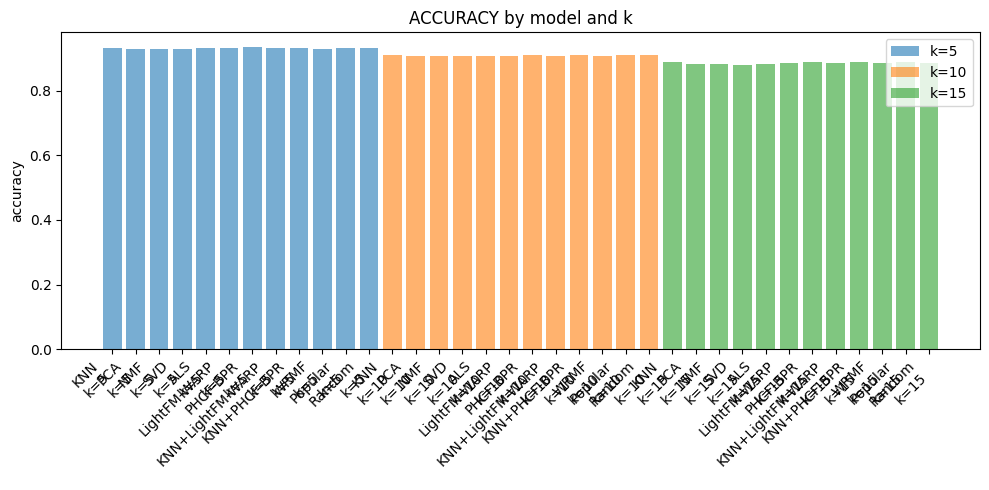

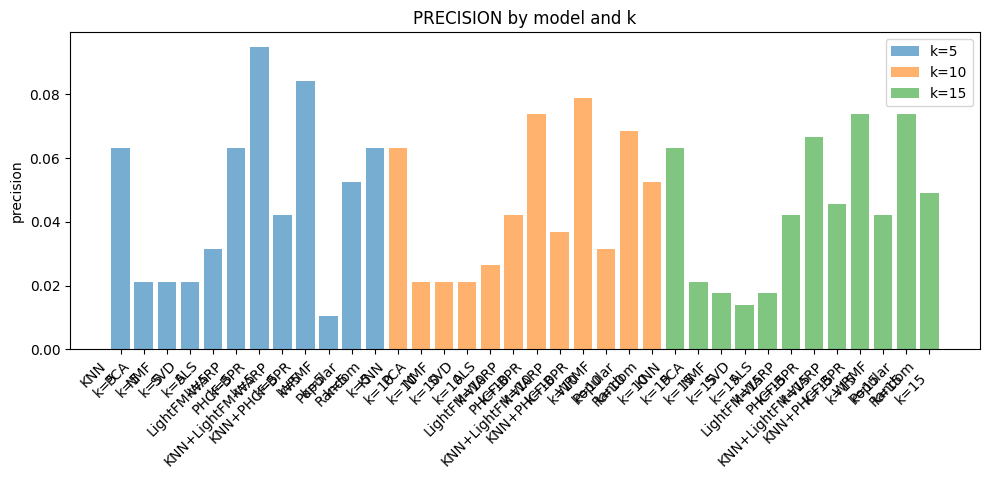

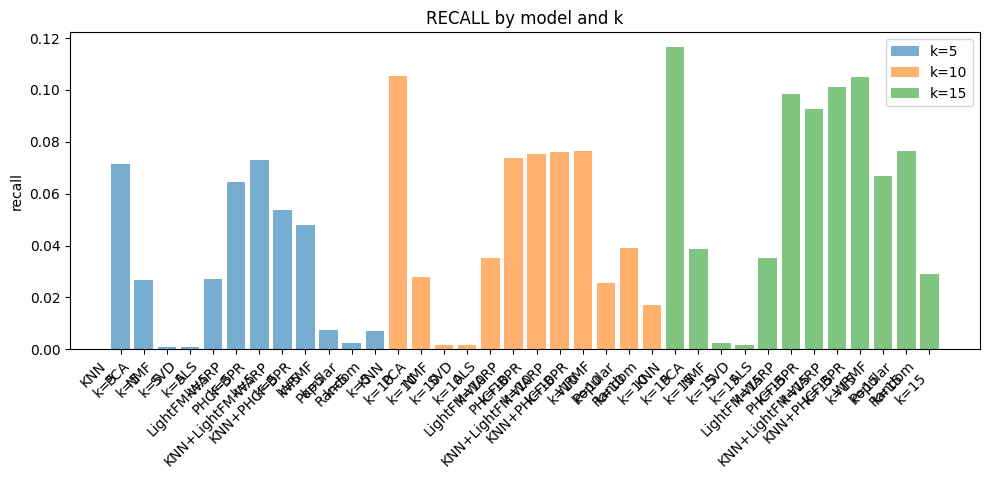

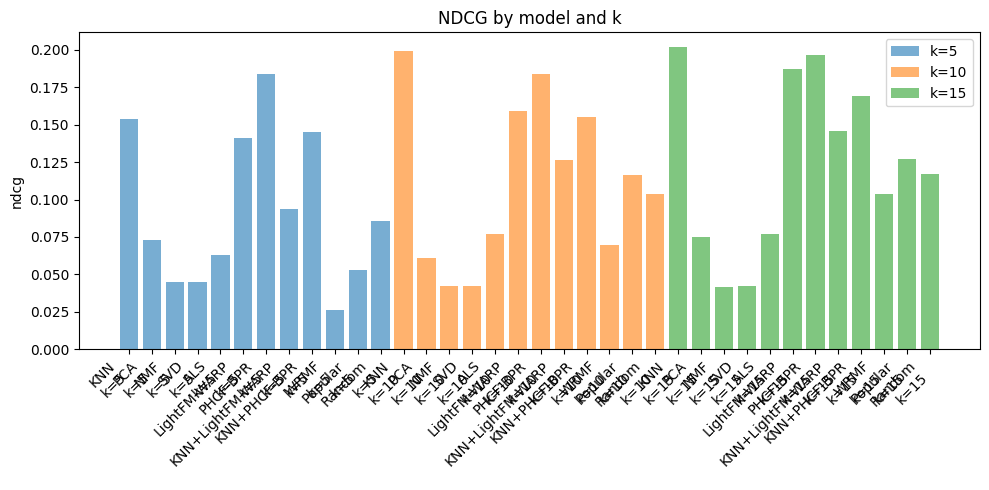

In [ ]:
k_values = [5, 10, 15]
results = {model: {k: {} for k in k_values} for model in models.keys()}



for name, model in models.items():
    print(f"\n=== {name} ===")
    if name == 'LightFM-WARP' or name == 'PHCF-BPR':
        model.fit(df_train, owners, mids)
        preds = model.predict()
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
        preds = model.predict()
    else:
        model.fit(X_train)
        preds = model.predict()

    for k in k_values:
        recs = get_recommendations(preds, used_train, popular_services, k)
        metrics = evaluate(recs, actual_test, mids, preds, k)
        results[name][k] = metrics
        print(f"\nk={k}:")
        for m, v in metrics.items():
            print(f"{m.capitalize()}: {v:.4f}")

# Визуализация
for metric in ['accuracy', 'precision', 'recall', 'ndcg']:
    plt.figure(figsize=(10, 5))
    for k in k_values:
        values = [results[model][k][metric] for model in models]
        plt.bar([f"{model}\nk={k}" for model in models], values, alpha=0.6, label=f"k={k}")
    plt.title(f"{metric.upper()} by model and k")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Сводная таблица средних метрик по модели
print("===== Average Metrics per Model =====")
avg_summary = {}
for model in models:
    avg = {metric: np.mean([results[model][k][metric] for k in k_values]) for metric in ['accuracy', 'precision', 'recall', 'ndcg']}
    avg_summary[model] = avg
    print(f"{model}:")
    for m, v in avg.items():
        print(f"  {m.capitalize()}: {v:.4f}")


===== Average Metrics per Model =====
KNN:
  Accuracy: 0.9106
  Precision: 0.0632
  Recall: 0.0978
  Ndcg: 0.1849
PCA:
  Accuracy: 0.9064
  Precision: 0.0211
  Recall: 0.0310
  Ndcg: 0.0696
NMF:
  Accuracy: 0.9062
  Precision: 0.0199
  Recall: 0.0016
  Ndcg: 0.0428
SVD:
  Accuracy: 0.9060
  Precision: 0.0187
  Recall: 0.0015
  Ndcg: 0.0431
ALS:
  Accuracy: 0.9066
  Precision: 0.0251
  Recall: 0.0325
  Ndcg: 0.0724
LightFM-WARP:
  Accuracy: 0.9088
  Precision: 0.0491
  Recall: 0.0788
  Ndcg: 0.1623
PHCF-BPR:
  Accuracy: 0.9117
  Precision: 0.0784
  Recall: 0.0803
  Ndcg: 0.1882
KNN+LightFM-WARP:
  Accuracy: 0.9085
  Precision: 0.0415
  Recall: 0.0768
  Ndcg: 0.1219
KNN+PHCF-BPR:
  Accuracy: 0.9120
  Precision: 0.0789
  Recall: 0.0765
  Ndcg: 0.1565
WRMF:
  Accuracy: 0.9076
  Precision: 0.0281
  Recall: 0.0333
  Ndcg: 0.0665
Popular:
  Accuracy: 0.9111
  Precision: 0.0649
  Recall: 0.0392
  Ndcg: 0.0986
Random:
  Accuracy: 0.9095
  Precision: 0.0550
  Recall: 0.0177
  Ndcg: 0.1022


In [ ]:
# Сводная таблица средних метрик по модели и экспорт всех метрик в Excel
import openpyxl
avg_summary_df = pd.DataFrame(avg_summary).T
avg_summary_df.index.name = 'Model'
writer = pd.ExcelWriter("model_comparison_summary.xlsx", engine="openpyxl")

# Средние метрики
avg_summary_df.index.name = 'Model'
# Добавляем цветовую заливку (heatmap) в Excel
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.formatting.rule import ColorScaleRule

avg_summary_df.to_excel(writer, sheet_name="Averages")
ws = writer.sheets["Averages"]

# Добавим цветовую шкалу к метрикам
color_rule = ColorScaleRule(start_type='min', start_color='FFFFFF',
                            mid_type='percentile', mid_value=50, mid_color='FFFF99',
                            end_type='max', end_color='63BE7B')

for col in range(2, 6):  # B to E (метрики)
    col_letter = chr(64 + col)
    ws.conditional_formatting.add(f"{col_letter}2:{col_letter}{1+len(avg_summary_df)}", color_rule)

# Метрики по каждому k
for k in k_values:
    k_df = pd.DataFrame({model: results[model][k] for model in models}).T
    k_df.index.name = 'Model'
    k_df.to_excel(writer, sheet_name=f"k={k}")

writer.close()

In [ ]:
!pip install --upgrade recbole deepctr-torch scipy scikit-learn pandas
import pandas as pd
import numpy as np
np.float_ = np.float64
np.complex_ = np.complex128
np.bool8 = np.bool_
np.unicode_ = np.str_

import torch
import torch.nn as nn
import torch.optim as optim
# RecBole imports for NCF and SASRec
from recbole.data import create_dataset, data_preparation
from recbole.quick_start import run_recbole
from recbole.config import Config
from recbole.model.general_recommender import NeuMF    # Neural CF model (NeuMF for NCF)
from recbole.model.sequential_recommender import SASRec  # SASRec sequential model
from recbole.trainer import Trainer
# DeepCTR-Torch imports for DeepFM
from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

# Преобразование X_train в DataFrame с рейтингами
user_indices, item_indices = X_train.nonzero()
ratings = X_train[user_indices, item_indices]

df_interactions = pd.DataFrame({
    'user_id': np.array(owners)[user_indices],
    'item_id': np.array(mids)[item_indices],
    'rating': ratings
})

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=32):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        user_emb = self.user_embed(user)
        item_emb = self.item_embed(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        return self.fc_layers(x).squeeze()

class NCFRecommender:
    def __init__(self, epochs=5, embed_dim=32, device='cpu'):
        self.epochs = epochs
        self.embed_dim = embed_dim
        self.device = device

    def fit(self, df_interactions, owners, mids):
        user2id = {u: i for i, u in enumerate(owners)}
        item2id = {i: j for j, i in enumerate(mids)}

        users = df_interactions['user_id'].map(user2id).values
        items = df_interactions['item_id'].map(item2id).values
        ratings = df_interactions['rating'].values

        self.model = NCF(len(owners), len(mids), self.embed_dim).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        users_tensor = torch.tensor(users, dtype=torch.long).to(self.device)
        items_tensor = torch.tensor(items, dtype=torch.long).to(self.device)
        ratings_tensor = torch.tensor(ratings, dtype=torch.float32).to(self.device)

        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            preds = self.model(users_tensor, items_tensor)
            loss = criterion(preds, ratings_tensor)
            loss.backward()
            optimizer.step()

    def predict(self):
        self.model.eval()
        num_users, num_items = self.model.user_embed.num_embeddings, self.model.item_embed.num_embeddings
        with torch.no_grad():
            user_idx = torch.arange(num_users).to(self.device)
            item_idx = torch.arange(num_items).to(self.device)
            preds = torch.zeros((num_users, num_items)).to(self.device)
            for u in user_idx:
                users_batch = u.repeat(num_items)
                preds[u] = self.model(users_batch, item_idx)
        return preds.cpu().numpy()


from deepctr_torch.inputs import SparseFeat
from deepctr_torch.models import DeepFM

# class DeepFMRecommender:
#     def __init__(self, epochs=10, embed_dim=8):
#         self.epochs = epochs
#         self.embed_dim = embed_dim
#         self.model = None
#         self.user2id = None
#         self.item2id = None

#     def fit(self, df_train, owners, mids):
#         # индексация
#         self.user2id = {user: idx for idx, user in enumerate(sorted(owners))}
#         self.item2id = {item: idx for idx, item in enumerate(sorted(mids))}

#         df_train['user_idx'] = df_train['owner'].map(self.user2id)
#         df_train['item_idx'] = df_train['mid'].map(self.item2id)
#         df_train = df_train.dropna(subset=['user_idx', 'item_idx'])
#         df_train[['user_idx', 'item_idx']] = df_train[['user_idx', 'item_idx']].astype(int)

#         # подготовка данных
#         positive_interactions = df_train[['user_idx', 'item_idx']]
#         user_list, item_list, labels = [], [], []
#         items_set = set(self.item2id.values())

#         for user in positive_interactions['user_idx'].unique():
#             pos_items = set(positive_interactions[positive_interactions['user_idx'] == user]['item_idx'])
#             num_pos = len(pos_items)
#             num_neg = num_pos

#             neg_candidates = list(items_set - pos_items)
#             if len(neg_candidates) >= num_neg:
#                 neg_items = np.random.choice(neg_candidates, num_neg, replace=False)
#             else:
#                 neg_items = np.random.choice(neg_candidates, len(neg_candidates), replace=False)

#             user_list.extend([user] * (num_pos + len(neg_items)))
#             item_list.extend(list(pos_items) + list(neg_items))
#             labels.extend([1] * num_pos + [0] * len(neg_items))

#         train_input = {'user': np.array(user_list), 'item': np.array(item_list)}
#         labels = np.array(labels)

#         feature_columns = [
#             SparseFeat('user', len(self.user2id), self.embed_dim),
#             SparseFeat('item', len(self.item2id), self.embed_dim)
#         ]

#         # обучение модели
#         self.model = DeepFM(feature_columns, feature_columns, task='binary')
#         self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
#         self.model.fit(train_input, labels, batch_size=256, epochs=self.epochs, verbose=2)

#     def predict(self):
#         num_users = len(self.user2id)
#         num_items = len(self.item2id)
#         preds = np.zeros((num_users, num_items))

#         for user in range(num_users):
#             user_input = {
#                 'user': np.array([user] * num_items),
#                 'item': np.arange(num_items)
#             }
#             preds[user] = self.model.predict(user_input, batch_size=512).reshape(-1)
#         return preds
class DeepFMRecommender:
    def __init__(self, embedding_dim=8, epochs=10, batch_size=256, lr=1e-3, verbose=2):
        self.embedding_dim = embedding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.user2id = {}
        self.item2id = {}
        self.feature_columns = None
        self.feature_names = None
        self.model = None

    def fit(self, df_train, owners, mids):
        # Индексация пользователей и элементов на основе предоставленных списков
        self.user2id = {user: idx for idx, user in enumerate(owners)}
        self.item2id = {item: idx for idx, item in enumerate(mids)}

        train_df = df_train.copy()
        train_df["user_id"] = train_df["owner"].map(self.user2id)
        train_df["item_id"] = train_df["mid"].map(self.item2id)

        # Удаление возможных NaN значений после маппинга
        train_df = train_df.dropna(subset=["user_id", "item_id"])
        train_df[["user_id", "item_id"]] = train_df[["user_id", "item_id"]].astype(int)

        num_users = len(owners)
        num_items = len(mids)

        # Подготовка негативных примеров
        positive_interactions = train_df[["user_id", "item_id"]]
        user_list, item_list, labels = [], [], []
        items_set = set(range(num_items))

        for user in positive_interactions["user_id"].unique():
            pos_items = set(positive_interactions[positive_interactions["user_id"] == user]["item_id"])
            num_pos = len(pos_items)
            num_neg = num_pos

            neg_candidates = list(items_set - pos_items)
            if len(neg_candidates) >= num_neg:
                neg_items = np.random.choice(neg_candidates, num_neg, replace=False)
            else:
                neg_items = neg_candidates  # если кандидатов меньше, чем нужно

            user_list.extend([user] * (num_pos + len(neg_items)))
            item_list.extend(list(pos_items) + list(neg_items))
            labels.extend([1] * num_pos + [0] * len(neg_items))

        train_model_input = {
            "user_id": np.array(user_list),
            "item_id": np.array(item_list)
        }
        labels = np.array(labels)

        # Feature columns для DeepFM
        self.feature_columns = [
            SparseFeat("user_id", vocabulary_size=num_users, embedding_dim=self.embedding_dim),
            SparseFeat("item_id", vocabulary_size=num_items, embedding_dim=self.embedding_dim)
        ]

        self.feature_names = get_feature_names(self.feature_columns)

        # Определение типа задачи (бинарная классификация)
        task_type = "binary"
        loss_name = "binary_crossentropy"
        metrics = ["accuracy"]

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = DeepFM(
            linear_feature_columns=self.feature_columns,
            dnn_feature_columns=self.feature_columns,
            task=task_type,
            device=device
        )

        self.model.compile(optimizer="adam", loss=loss_name, metrics=metrics)
        self.model.fit(
            train_model_input,
            labels,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            validation_split=0.0
        )

    def predict(self):
        num_users = len(self.user2id)
        num_items = len(self.item2id)

        # Формируем данные для всех пар пользователей и элементов
        user_arr = np.repeat(np.arange(num_users), num_items)
        item_arr = np.tile(np.arange(num_items), num_users)

        model_input = {
            "user_id": user_arr,
            "item_id": item_arr
        }

        preds = self.model.predict(model_input, batch_size=self.batch_size).reshape(num_users, num_items)
        return preds

class SASRec(nn.Module):
    def __init__(self, num_items, embed_dim=50, max_seq_len=50, num_heads=1, num_layers=2, dropout=0.2):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.item_emb = nn.Embedding(num_items + 1, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_seq_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, num_items + 1)

    def forward(self, seq):
        seq_len = seq.size(1)
        pos_ids = torch.arange(seq_len, device=seq.device).unsqueeze(0).expand_as(seq)
        seq_emb = self.item_emb(seq) + self.pos_emb(pos_ids)
        mask = (seq == 0)
        transformer_out = self.transformer(seq_emb, src_key_padding_mask=mask)
        logits = self.fc(transformer_out[:, -1, :])
        return logits

class SASRecRecommender:
    def __init__(self, epochs=10, embed_dim=50, max_seq_len=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.epochs = epochs
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.device = device

    def fit(self, df_train, owners, mids):
        self.user2id = {user: idx for idx, user in enumerate(owners)}
        self.item2id = {item: idx+1 for idx, item in enumerate(mids)}  # padding_idx=0

        user_seq = df_train.sort_values('start_time').groupby('owner')['mid'].apply(
            lambda items: [self.item2id[i] for i in items if i in self.item2id])

        self.model = SASRec(num_items=len(mids), embed_dim=self.embed_dim,
                            max_seq_len=self.max_seq_len).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0
            for user, seq in user_seq.items():
                if len(seq) < 2:
                    continue
                seq_input = seq[:-1][-self.max_seq_len:]
                target = seq[-1]
                seq_input = [0]*(self.max_seq_len - len(seq_input)) + seq_input
                seq_tensor = torch.tensor([seq_input], device=self.device)
                target_tensor = torch.tensor([target], device=self.device)

                optimizer.zero_grad()
                logits = self.model(seq_tensor)
                loss = loss_fn(logits, target_tensor)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}')

    def predict(self):
        self.model.eval()
        num_users = len(self.user2id)
        num_items = len(self.item2id)
        scores = np.zeros((num_users, num_items))

        for user, uidx in self.user2id.items():
            seq = []
            seq_tensor = torch.tensor([[0]*self.max_seq_len], device=self.device)
            with torch.no_grad():
                logits = self.model(seq_tensor)
                scores[uidx, :] = logits.cpu().numpy()[0, 1:]

        return scores

In [ ]:
used_train = get_used_services(X_train)
actual_test = get_used_services(X_test)

# Подготовка данных из X_train
user_indices, item_indices = X_train.nonzero()
ratings = X_train[user_indices, item_indices]

df_interactions = pd.DataFrame({
    'user_id': np.array(owners)[user_indices],
    'item_id': np.array(mids)[item_indices],
    'rating': ratings
})



models = {
    'KNN': KNNRecommender(),
    'PCA': SVDRecommender(PCA(n_components=5)),
    'NMF': SVDRecommender(NMF(n_components=5, init='random', random_state=0)),
    'SVD': SVDRecommender(TruncatedSVD(n_components=5)),'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'LightFM-WARP': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'PHCF-BPR': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'KNN+LightFM-WARP': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'KNN+PHCF-BPR': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'WRMF': WRMFRecommender(),
    'NCF': NCFRecommender(),
    'DeepFM': DeepFMRecommender(),
    'SASRec': SASRecRecommender(),
    'Popular': PopularRecommender(popular_services),
    'Random': RandomRecommender(),
}

k_values = [5, 10, 15]
results = {model: {k: {} for k in k_values} for model in models.keys()}

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name in ['LightFM-WARP','DeepFM', 'PHCF-BPR', 'SASRec']:
        model.fit(df_train, owners, mids)
    elif name in ['NCF', 'SASRec']:
        model.fit(df_interactions, owners, mids)
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
    else:
        model.fit(X_train)

    preds = model.predict()
    for k in k_values:
        recs = get_recommendations(preds, used_train, popular_services, k)
        metrics = evaluate(recs, actual_test, mids, preds, k)
        results[name][k] = metrics
        print(f"\nk={k}:")
        for m, v in metrics.items():
            print(f"{m.capitalize()}: {v:.4f}")


loss=warp, epochs=10, no_components=10 -> {'accuracy': np.float64(0.8865379529225073), 'precision': np.float64(0.04912280701754386), 'recall': np.float64(0.11186970923813028), 'ndcg': np.float64(0.2078960827559154)}
loss=warp, epochs=10, no_components=20 -> {'accuracy': np.float64(0.8854800317376356), 'precision': np.float64(0.042105263157894736), 'recall': np.float64(0.09612010796221322), 'ndcg': np.float64(0.18961643644355583)}
loss=warp, epochs=10, no_components=40 -> {'accuracy': np.float64(0.8854800317376356), 'precision': np.float64(0.042105263157894736), 'recall': np.float64(0.10412891202364886), 'ndcg': np.float64(0.20297888273929263)}
loss=warp, epochs=20, no_components=10 -> {'accuracy': np.float64(0.8860089923300714), 'precision': np.float64(0.045614035087719294), 'recall': np.float64(0.10457875457875457), 'ndcg': np.float64(0.19359026300292123)}
loss=warp, epochs=20, no_components=20 -> {'accuracy': np.float64(0.887066913514943), 'precision': np.float64(0.05263157894736842)